## Chargement des données nettoyées

In [1]:
# Load libraries
import numpy as np
import pandas as pd

In [2]:
# Load binary file with cleaned data
data = pd.read_feather("p5_data.ft")

ImportError: Missing optional dependency 'pyarrow'.  Use pip or conda to install pyarrow.

In [44]:
# Visualisation par t-SNE

# Algorithmes de segmentation

* **Algorithmes**
    * Clustering hiérarchique (dendogramme, links)
    * k-means (k-means++, avec et sans noyau)
    * DBSCAN


* **Métriques**
    * Forme des clusters : coefficient de silhouette (latex)
    * Stabilité de l'algorithme
    * Compatibilité avec les connaissance du domaine : indice de Rand ajusté (latex)

* 

## II. Clustering hierarchique

### II.A Application de l'algorithme de clustering hierarchique

In [8]:
# Clustering hiérarchique (critère de Ward)
from scipy.cluster.hierarchy import linkage
Z = linkage(X_std, 'ward')

In [9]:
# Fonction d'affichage du dendrogramme
from scipy.cluster.hierarchy import fcluster, dendrogram

def plot_dendrogram(Z, names,p):
    plt.figure(figsize=(25,10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('observations')
    plt.ylabel('distance')
    dendrogram(
        Z,
        p=10,
        labels = names,
        truncate_mode = "lastp"
    )
    plt.show()

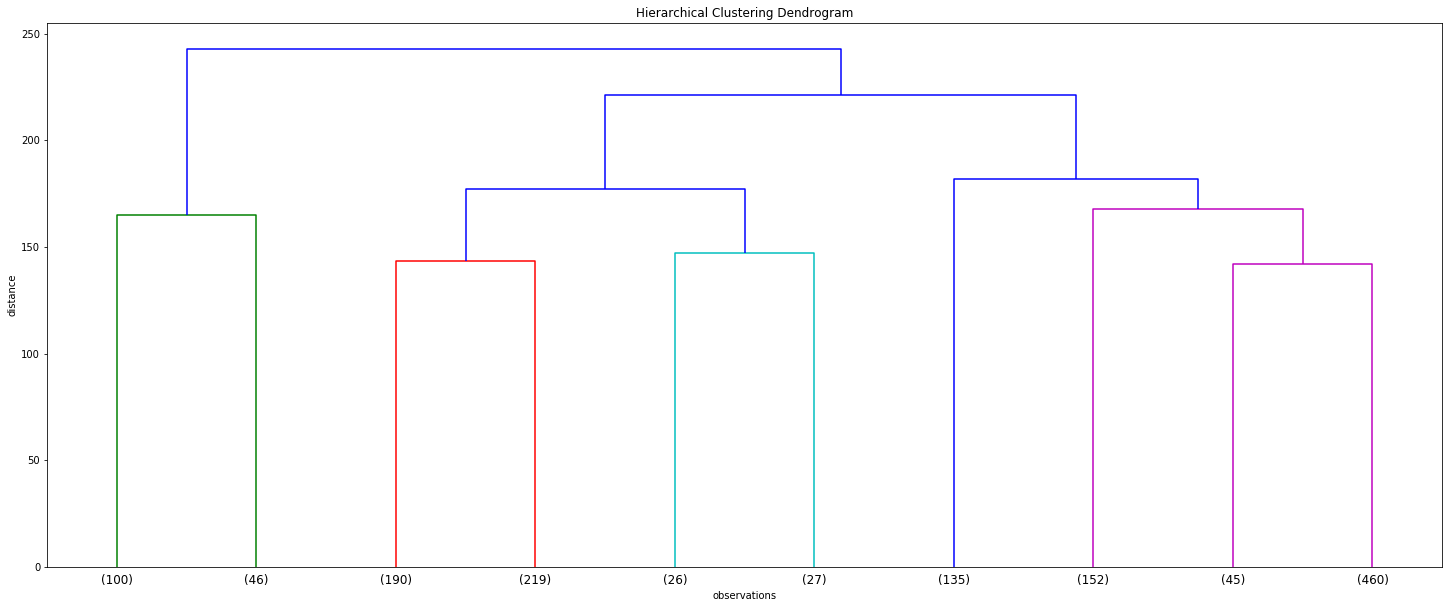

In [10]:
# Affichage du dendrogramme
names = y
p = 10 # on se limite à afficher 10 clusters
plot_dendrogram(Z, names,p)

In [11]:
# Coupage du dendrogramme à 10 clusters
clusters = fcluster(Z, 10, criterion='maxclust')

### II.B Réduction dimensionnelle (et visualisation) avec t-SNE

In [12]:
# Application du t-SNE, initialisé par une ACP
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, init='pca', random_state=42)
X_projected = tsne.fit_transform(X_std) # TSNE ne possède pas de méthode ".transform()"

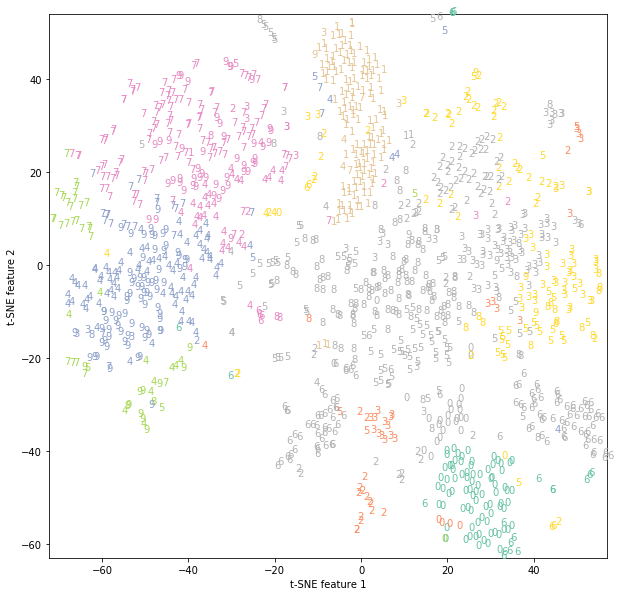

In [13]:
# Représentation graphique du clustering
plt.figure(figsize=(10,10))
plt.xlim(X_projected[:,0].min(),X_projected[:,0].max())
plt.ylim(X_projected[:,1].min(),X_projected[:,1].max())
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")

# les glyphes représentent les classes réelles, et les couleurs les clusters obtenus
for i in range(len(X_projected)):
    plt.text(X_projected[:,0][i], X_projected[:,1][i],
        y[i],  # le point i est représenté par son chiffre
        color=plt.cm.Set2(clusters[i]/10.)
    )

>Certaines classes sont biens distinguées par l'algorithme de clustering hierarchique : notamment les 1 et les 0. Les autres sont beaucoup plus "mélangées".

### II.C Évaluations avec coefficient de silhouette et ARI

In [14]:
# Évaluation intrinséque de la qualité de ce partitionnement
# avec le coefficient de silhouette
from sklearn import metrics

silhouette = metrics.silhouette_score(X_std,clusters)
print(silhouette) # Values closer to 1 indicate a better partition.

-0.034870269799448385


In [15]:
# Évaluation extrinséque de la qualité de ce partitionnement
# avec l'indice de Rand ajusté
from sklearn import metrics

ari = metrics.adjusted_rand_score(y,clusters)
print(ari) # Values closer to 1 indicate a better partition.

0.289320619628567


## III k-MEANS

### III.A Application de l'algorithme de k-means

In [16]:
from sklearn import cluster
n_clusters = 10 # on veut partitionner notre jeu de données en 10
# nous conservons l'initialisation par défaut avec k-means++
kmeans = cluster.KMeans(n_clusters = n_clusters)
kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### II.B Réduction dimensionnelle (et visualisation) avec ACP (linéaire, puis à noyau)

In [17]:
# Décomposition par ACP
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_std)

# Projection des points sur les composantes principales
X_projected = pca.transform(X_std)

# Pourcentage de variance expliquée par ACP
print(pca.explained_variance_ratio_.cumsum())

[0.06882484 0.11811328]


> Nous constatons que les deux premières composantes n'expliquent que 12% de la variance observée. La représentation que nous allons obtenir n'est pas très pertinentes.

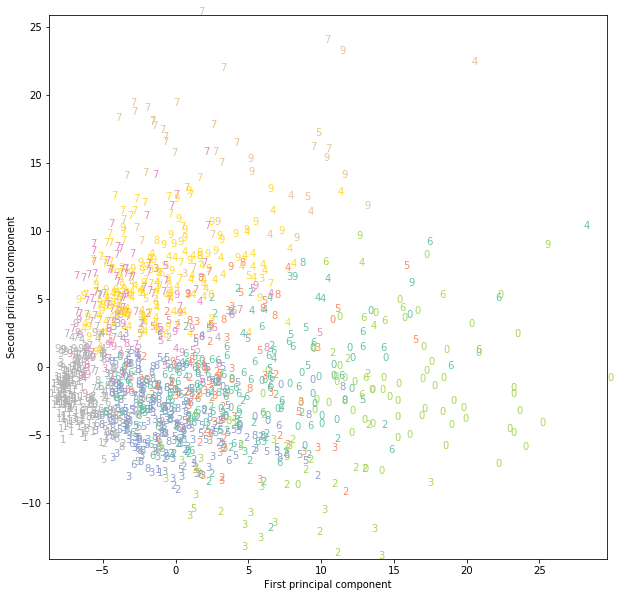

In [18]:
# Représentation graphique
plt.figure(figsize=(10,10))
plt.xlim(X_projected[:,0].min(),X_projected[:,0].max())
plt.ylim(X_projected[:,1].min(),X_projected[:,1].max())
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

# les glyphes représentent les classes réelles, et les couleurs les clusters obtenus
for i in range(len(X_projected)):
    plt.text(X_projected[:,0][i], X_projected[:,1][i],
        y[i],  # le point i est représenté par son chiffre
        color=plt.cm.Set2(kmeans.labels_[i]/10.)
    )

In [19]:
# Décomposition par ACP avec noyau
from sklearn import decomposition

kpca = decomposition.KernelPCA(n_components=2, kernel='rbf', gamma=10)
kpca.fit(X_std)

# Projection des points sur les composantes principales
X_projected = kpca.transform(X_std)

> Il n'existe pas sous scikit-learn de mesure similaire à explained_variance_ratio_ pour les ACP à noyau. Il est donc difficile de savoir a priori si la représentation obtenue sera pertinente.

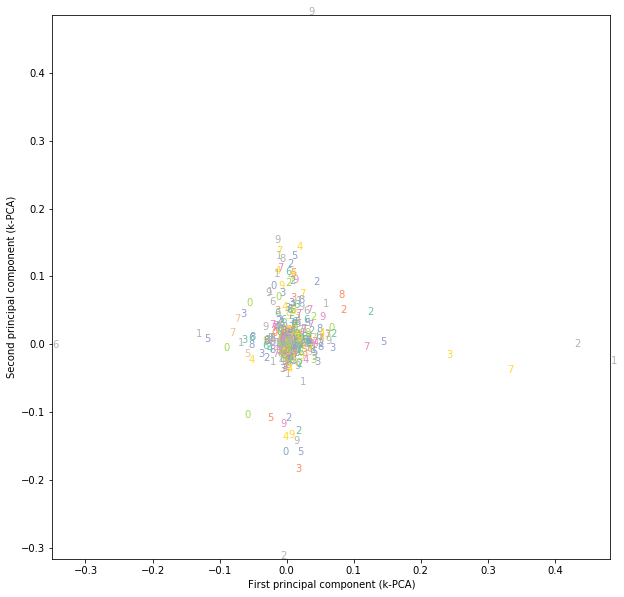

In [20]:
# Représentation graphique
plt.figure(figsize=(10,10))
plt.xlim(X_projected[:,0].min(),X_projected[:,0].max())
plt.ylim(X_projected[:,1].min(),X_projected[:,1].max())
plt.xlabel("First principal component (k-PCA)")
plt.ylabel("Second principal component (k-PCA)")

# les glyphes représentent les classes réelles, et les couleurs les clusters obtenus
for i in range(len(X_projected)):
    plt.text(X_projected[:,0][i], X_projected[:,1][i],
        y[i],  # le point i est représenté par son chiffre
        color=plt.cm.Set2(kmeans.labels_[i]/10.)
    )

>On constate qu'une projection sur les deux composantes principales d'une ACP avec noyau ne permet pas d'illustrer fidèlement le phénomène observé. Le t-SNE obtient de bien meilleurs résultats.

### III.C Évaluation avec indice de Davies-Bouldin et ARI

In [21]:
# Évaluation intrinséque de la qualité de ce partitionnement
# avec l'indice de Davies-Bouldin
from sklearn import metrics
db = metrics.davies_bouldin_score(X_std,kmeans.labels_)
print(db) # Values closer to 0 indicate a better partition.

3.229245374713036


C:\Users\Lebrun\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [22]:
# Évaluation extrinséque de la qualité de ce partitionnement
# avec l'indice de Rand ajusté
from sklearn import metrics
ari = metrics.adjusted_rand_score(y,kmeans.labels_)
print(ari) # Values closer to 1 indicate a better partition.

0.24899868668511985


## IV DBSCAN

### III.A Application de l'algorithme DBSCAN

In [23]:
# Compute DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=5, min_samples=3)
db.fit(X_std)

DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=None, p=None)

In [24]:
# Number of clusters in labels, ignoring noise if present.
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 6


> En jouant sur la valeur des hyper-paramètres eps et min_samples, nous pouvons modifier le nombre de classes trouvées par l'algorithme. Néanmoins, aucunes valeurs de ces hyper-paramètres ne permet de retrouver les 10 clusters du jeu de données initiales. Contrairement au k-means et au clustering hierarchique, DBSCAN ne permet pas de sélectionner le nombre de clusters.

### II.B Réduction dimensionnelle (et visualisation) avec Isomap

In [25]:
# Application de l'algorithme Isomap
from sklearn import manifold

isomap = manifold.Isomap(n_components=2)
isomap.fit_transform(X_std)

# Projection des points sur la variété
X_projected = isomap.transform(X_std)
X_projected.shape

(1400, 2)

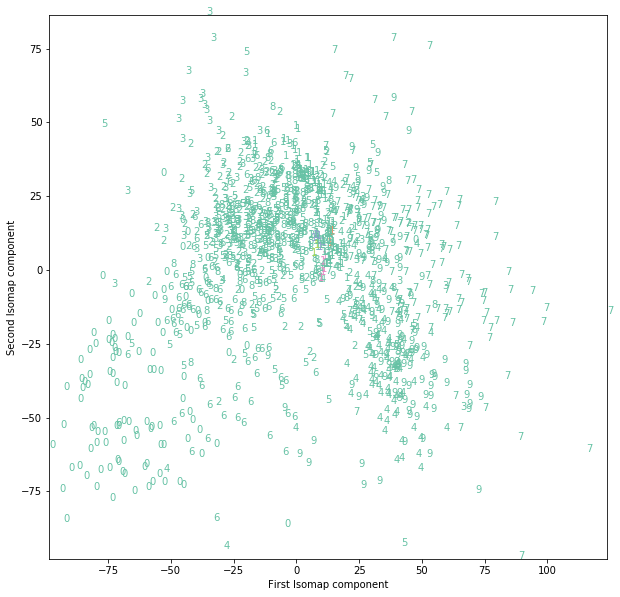

In [26]:
# Représentation graphique
# Représentation graphique
plt.figure(figsize=(10,10))
plt.xlim(X_projected[:,0].min(),X_projected[:,0].max())
plt.ylim(X_projected[:,1].min(),X_projected[:,1].max())
plt.xlabel("First Isomap component")
plt.ylabel("Second Isomap component")

# les glyphes représentent les classes réelles, et les couleurs les clusters obtenues
for i in range(len(X_projected)):
    plt.text(X_projected[:,0][i], X_projected[:,1][i],
        y[i],  # le point i est représenté par son chiffre
        color=plt.cm.Set2(db.labels_[i]/10.)
    )

### IV.C Évaluation avec coefficient de silhouette et ARI

In [27]:
# Évaluation intrinséque de la qualité de ce partitionnement
# avec le coefficient de silhouette
from sklearn import metrics

silhouette = metrics.silhouette_score(X_std,db.labels_)
print(silhouette) # Values closer to 1 indicate a better partition.

-0.2328548174738839


In [28]:
# Évaluation extrinséque de la qualité de ce partitionnement
# avec l'indice de Rand ajusté
from sklearn import metrics

ari = metrics.adjusted_rand_score(y,db.labels_)
print(ari) # Values closer to 1 indicate a better partition.

0.00025763139540239195


# Consignes

L’intention de ce projet est de réaliser une segmentation de clients, au travers de la préparation et mise en œuvre de transformations de features numériques et catégorielles (features engineering), de la mise en œuvre des modèles d’apprentissage non supervisés, de la sélection d’un modèle et l’optimisation de ses hyperparamètres.

Le nombre de segments de clients doit permettre de bien différencier les clients, afin que l’équipe Marketing puisse mettre en place des actions ciblées, mais doit rester raisonnable afin de maîtriser leur charge de travail proportionnelle à ce nombre.

L’étudiant pourra s’inspirer de démarches de segmentation connues en fonction des données à disposition, afin de créer les features adaptées. :
 * segmentation RFM,
 * segmentation Personae,
 * segmentation "à la performance",
 * segmentation comportementales, …)

Incitez l’étudiant à mettre en œuvre des fonctions de comparaison des résultats des modèles selon différents indicateurs (score, temps de calcul, …), permettant de choisir celui adapté à la problématique et aux moyens techniques à disposition.

# <span style="color:red">**QUESTIONS & TO FIX LIST**</span>